In [2]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def split_train_test(data, target, test_size):
    nb_samples = len(target)
    nb_test = int(test_size * nb_samples)

    shuffle = list(range(nb_samples))
    random.shuffle(shuffle)

    X_train, X_test, y_train, y_test = [], [], [], []
    
    nb_0 = 0
    nb_1 = 0

    for idx in shuffle:
        if nb_0 < (nb_test//2) and target[idx]==0:
            y_test.append(0)
            X_test.append(data[idx])
            nb_0 += 1
        elif nb_1 < (nb_test//2) and target[idx]==1:
            y_test.append(1)
            X_test.append(data[idx])
            nb_1 += 1
        else:
            y_train.append(target[idx])
            X_train.append(data[idx])
    
    return X_train, X_test, y_train, y_test

def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [4]:
def aggregateData(dataGroup, id_list, window_time):
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):

        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")
        
        data_patient = []

        df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)

        # idx_variables_kept = [0,1,2,3,4,5,6,7,8]
        idx_variables_kept = [0,1,3,4,6,7,8]
        df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        df_dynamic = df_dynamic.iloc[:,idx_variables_kept]

        statics = list(df_static.to_numpy()[0])
        # CAS OU TOUTE UNE COLONNE EST MASQUEE ?
        mean = df_dynamic_masked.mean().tolist()
        sd = df_dynamic_masked.std().tolist()
        median = df_dynamic_masked.median().tolist()
        maxi = df_dynamic_masked.max().tolist()
        mini = df_dynamic_masked.min().tolist()
        first = list(df_dynamic.to_numpy()[0,:])
        last = list(df_dynamic.to_numpy()[window_time*24-1,:])

        data_patient.extend(mean)
        data_patient.extend(sd)
        # data_patient.extend(median)
        data_patient.extend(maxi)
        data_patient.extend(mini)
        # data_patient.extend(first)
        # data_patient.extend(last)
        data_patient.extend(statics)

        data.append(data_patient)
    
    return data

def prepareDeathList(dataGroup, window_time):
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"
    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    target = []
    id_list = []

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            id_list.append(encounterId)
            
            delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
            if delai_sortie_deces <= 1:
                target.append(1)
            else:
                target.append(0)
    
    return target, id_list

In [43]:
# dataGroup = "dataECMO"
dataGroup = "dataRangueil"

window_time_days = 5
target, id_list = prepareDeathList(dataGroup, window_time_days)
data = aggregateData(dataGroup, id_list, window_time_days)

print(f"Nb patients: {len(target)}")
print(f"Nb Deceased: {np.sum(target)}")
print(f"Nb Survived: {len(target) - np.sum(target)}")

100%|██████████| 1794/1794 [02:41<00:00, 11.09it/s]

Nb patients: 1794
Nb Deceased: 478
Nb Survived: 1316


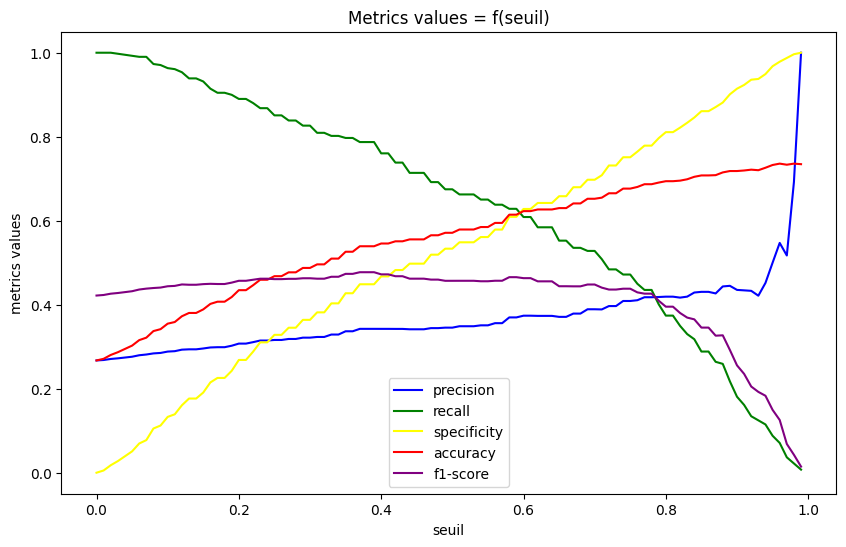

In [44]:
if dataGroup == "dataECMO":
    dataPath = "../dataECMO/"
else:
    dataPath = "../dataRea/"

y_pred_proba = []
y_pred = []
y_true = []

i = 0
for encounterId in id_list:

    df_igs = pd.read_parquet(dataPath + "finalData/" + encounterId + "/IGS.parquet")

    igs_mortalites_predites = df_igs.iloc[:,1].to_numpy()
    igss_pred = [float(igs_str[20:][:-1].replace(",","."))/100 for igs_str in igs_mortalites_predites]

    if len(igss_pred) > 0:
        igs_pred = igss_pred[0]
        y_pred_proba.append(igs_pred)
        y_pred.append(int(igs_pred > 0.5))
        y_true.append(target[i])
    
    i+=1


precisions_seuil = []
recalls_seuil = []
tnrs_seuil = []
accuracies_seuil = []
f1s_seuil = []

seuils = [s/100 for s in range(0,100)]

for seuil in seuils:

    y_pred = (np.array(y_pred_proba) > seuil).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    tnr = tnr_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    precisions_seuil.append(precision)
    recalls_seuil.append(recall)
    tnrs_seuil.append(tnr)
    f1s_seuil.append(f1)
    accuracies_seuil.append(accuracy)
    

auroc = roc_auc_score(y_true, y_pred_proba)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
tnr = tnr_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

plt.figure(figsize=(10, 6))

plt.plot(seuils, precisions_seuil, label='precision', color='blue')
plt.plot(seuils, recalls_seuil, label='recall', color='green')
plt.plot(seuils, tnrs_seuil, label='specificity', color='yellow')
plt.plot(seuils, accuracies_seuil, label='accuracy', color='red')
plt.plot(seuils, f1s_seuil, label='f1-score', color='purple')

plt.xlabel('seuil')
plt.ylabel('metrics values')
plt.title('Metrics values = f(seuil)')

plt.legend()

plt.show()

AUROC: 0.7202
Precision: 0.3186
Recall: 0.9162
Specificity: 0.2890
Accuracy: 0.4559
F1 Score: 0.4721


<Axes: xlabel='prediction', ylabel='Count'>

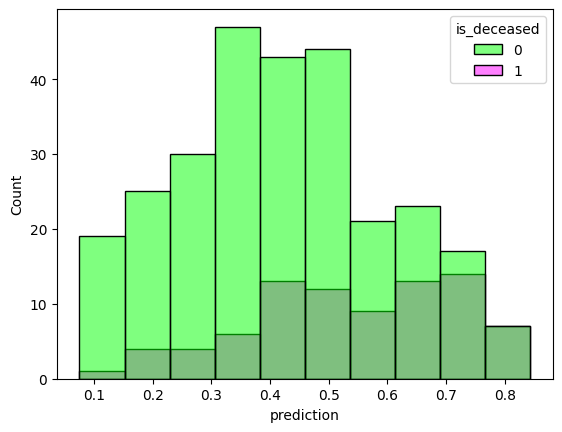

In [37]:
from pandas import DataFrame


aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

for i in range(1000):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    while np.sum(y_test) == 0:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

    # y_train_np = np.array(y_train)
    # nb_tot = np.size(y_train_np)
    # nb_1 = np.sum(y_train_np)
    # nb_0 = nb_tot - nb_1

    # idx = 0
    # while nb_1 < nb_0:
    #     if idx >= nb_tot:
    #         idx = 0
    #     elif y_train_np[idx] == 1:
    #         X_train.append(data[idx])
    #         y_train.append(1)
    #         nb_1 += 1
    #     idx += 1

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'num_leaves': 5,
        'learning_rate': 0.05,
        'feature_fraction': 0.75,
        'verbose': -1,
        'class_weight' : class_weights
    }

    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.3).astype(int)

    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    aurocs.append(auroc)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    f1s.append(f1)
    accuracies.append(accuracy)

    df = pd.DataFrame({'prediction': y_pred_proba, 'is_deceased': y_test})
    

print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"Specificity: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

sns.histplot(data=df, x="prediction", hue="is_deceased",bins=10, palette=['#00FF00', '#FF00FF'])

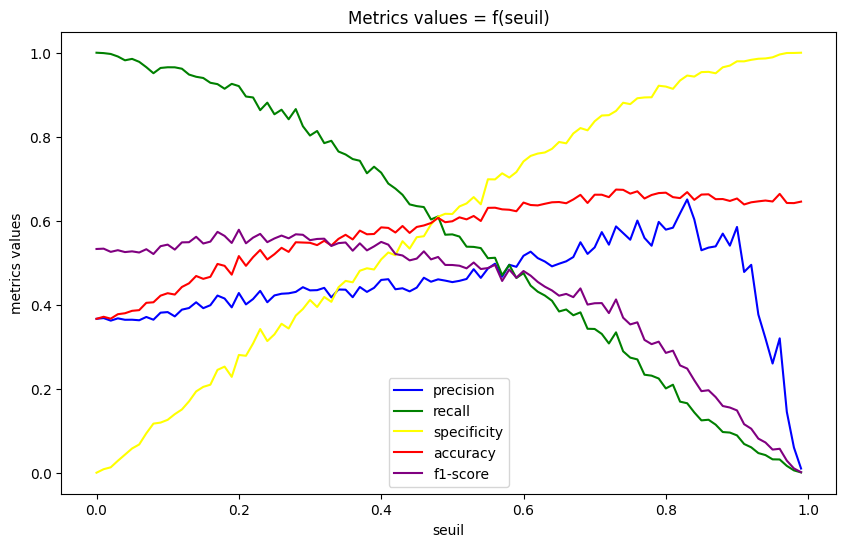

In [27]:
precisions_seuil = []
recalls_seuil = []
tnrs_seuil = []
accuracies_seuil = []
f1s_seuil = []

seuils = [s/100 for s in range(0,100)]

for seuil in seuils:
    
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
        while np.sum(y_test) == 0:
            X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
            

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = dict(enumerate(class_weights))
        
        params = {
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'num_leaves': 5,
            'learning_rate': 0.05,
            'feature_fraction': 0.75,
            'verbose': -1,
            'class_weight' : class_weights
        }

        # clf = lgb.LGBMClassifier(**params)
        clf = LogisticRegression(solver='sag', penalty='l2', verbose=0, max_iter=1000, class_weight=class_weights)
        clf.fit(X_train, y_train)
        
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        
        y_pred = (y_pred_proba > seuil).astype(int)

        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        tnr = tnr_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
    
    precisions_seuil.append(np.mean(precisions))
    recalls_seuil.append(np.mean(recalls))
    tnrs_seuil.append(np.mean(tnrs))
    accuracies_seuil.append(np.mean(accuracies))
    f1s_seuil.append(np.mean(f1s))


plt.figure(figsize=(10, 6))

plt.plot(seuils, precisions_seuil, label='precision', color='blue')
plt.plot(seuils, recalls_seuil, label='recall', color='green')
plt.plot(seuils, tnrs_seuil, label='specificity', color='yellow')
plt.plot(seuils, accuracies_seuil, label='accuracy', color='red')
plt.plot(seuils, f1s_seuil, label='f1-score', color='purple')

plt.xlabel('seuil')
plt.ylabel('metrics values')
plt.title('Metrics values = f(seuil)')

plt.legend()

plt.show()

In [1]:
import shap

# Create a TreeExplainer object for the LightGBM model
explainer = shap.Explainer(clf)

X_test = np.array(X_test)
# Calculate SHAP values for the test set
shap_values = explainer(np.array(X_test))

shap.summary_plot(shap_values, X_test)

NameError: name 'clf' is not defined

In [251]:
aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

for i in range(1000):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    while np.sum(y_test) == 0:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

    pos_weight = np.sum(np.array(y_train) == 0) / np.sum(np.array(y_train) == 1)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.1,
        'max_depth': 5,
        'verbosity': 0,
        'n_estimator': 100
    }

    # Initialize and train the classifier
    clf = xgb.XGBClassifier(**params)
    # clf = xgb.XGBClassifier(
    # learning_rate=0.1,
    # max_depth=5,
    # n_estimators=100,
    # objective='binary:logistic',
    # class_weights
    # )
    
    clf.fit(X_train, y_train)
    
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    aurocs.append(auroc)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    f1s.append(f1)
    accuracies.append(accuracy)


print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"Specificity: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

AUROC: 0.7195
Precision: 0.5435
Recall: 0.2805
Specificity: 0.9139
Accuracy: 0.7451
F1 Score: 0.3678


In [13]:
aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

for i in range(100):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    while np.sum(y_test) == 0:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

    base_classifier = DecisionTreeClassifier()

    clf = BaggingClassifier(estimator=base_classifier, n_estimators=100)

    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    aurocs.append(auroc)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    f1s.append(f1)
    accuracies.append(accuracy)


print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"Specificity: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

AUROC: 0.6398
Precision: 0.5158
Recall: 0.3065
Specificity: 0.8300
Accuracy: 0.6374
F1 Score: 0.3675


In [19]:
aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

for i in range(1000):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    while np.sum(y_test) == 0:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    clf = LogisticRegression(solver='sag', penalty='l2', verbose=0, max_iter=1000, class_weight=class_weights)

    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    aurocs.append(auroc)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    f1s.append(f1)
    accuracies.append(accuracy)


print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"Specificity: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

ValueError: Solver sag supports only 'l2' or None penalties, got l1 penalty.